In [1]:
#base libraries for filemanagement etc
import os
import glob
from tqdm import tqdm
import random
import tarfile
import warnings
warnings.filterwarnings('ignore')

#data handling and visualiation libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#image aug libraries
from PIL import Image #using library pillow

#pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader,Dataset,WeightedRandomSampler,random_split
from torch.optim import Adam
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import torchmetrics
import torchinfo

In [40]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

%matplotlib inline
plt.ion()   # interactive mode

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
from torchsummary import summary

In [4]:
%matplotlib inline

In [5]:
# use cuda if it is available else use cpu, cuda can handle more data and does training faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
RANDOM_SEED = 115
torch.cuda.manual_seed(RANDOM_SEED)

In [7]:
img_dims = 224
target_size = (img_dims, img_dims) # size of dataset images


In [9]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [255]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),     
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1 , saturation = 0.1), #random brightness, contrast etc

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize((256,256), antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'test': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize((256,256), antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}


In [256]:
data_dir = '/kaggle/input/sg-food/sg_food' 
subfolder = {'train': 'train', 'val': 'val', 'test': 'test'}

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


# Visualise dataset

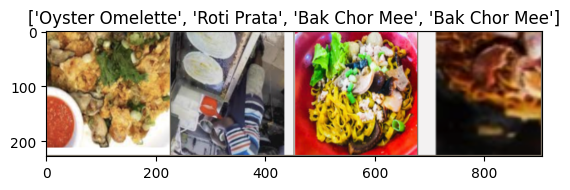

In [53]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [257]:
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

In [252]:
# Labels
def get_model_results(model, data_loader):
    loop = tqdm(data_loader, total=len(data_loader))

    y_preds = []
    y_trues = []
    
    # Assuming device is defined elsewhere in your code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.inference_mode():
        model.eval()
        for X, y_true in loop:
            X = X.to(device)
            y_true = y_true.to(device)
            
            y_pred = model(X)
            _, y_pred_class = torch.max(y_pred, 1)

            y_preds.extend(y_pred_class.data.cpu().numpy())
            y_trues.extend(y_true.data.cpu().numpy())

    print(f"{len(data_loader.dataset)} images")
    return y_preds, y_trues
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,f1_score

def print_classification_report(y_trues,y_preds,dataset_name=''):
    print(f'Classification Report: {dataset_name}')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_trues, y_preds)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in selected_classes],
                         columns = [i for i in selected_classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True,fmt='g')

    # Set the axis labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    print('Accuracy: ', accuracy_score(y_trues,y_preds))
    print('F1 Score: ', f1_score(y_trues,y_preds,average='macro'))
    
    
    plt.show()
    plt.savefig(f"{dataset_name} Confusion Matrix.jpg", dpi=600)
    

# Knowledge Distillation training

### Define Teacher Vision Transformer

In [56]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels, other_argument=None):
        super(ViTForImageClassification, self).__init__()
        # Your model initialization code here
        # Example:
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels=None):
        # Your forward pass code here
        # Example:
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)

        if labels is not None:
            # Calculate loss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits

# initialize teacher and student

In [192]:
# Instantiate the Vision Transformer model as the teacher model
teacher_type = "VisionTransformer"
teacher_model = ViTForImageClassification(5) # 5 classes

teacher_model = torch.load('/kaggle/input/4414visiontransformer/model_ViT.pt')
teacher_model.classifier = nn.Linear(in_features=768, out_features=5, bias=True)
teacher_model = teacher_model.to(device)
teacher_model.eval()
teacher_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [234]:
# Instantiate the student model
student_type = "Resnet18"
student_model = models.resnet18(pretrained=True)

# change the final layer of ResNet Model for Transfer Learning
fc_inputs = student_model.fc.in_features
student_model.fc = nn.Sequential(nn.Linear(fc_inputs, 5)) # change no. of classes
student_model = student_model.to(device)
summary(student_model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [235]:
torch.cuda.empty_cache()
import gc
gc.collect()

9

# training prep

In [236]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validation_step(model, batch):
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)
    teacher_pred = teacher_model(images)                  # Generate predictions
    out = model(images) 
    loss = 0.5*(distillation_loss(out, teacher_pred, temperature)) + 0.5*(criterion(out, labels))   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], last_lr: {:.8f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    if result['val_acc']>0.93:
        torch.save(student_model.state_dict(), f'{student_type}-student_of_{teacher_type}_{temperature}_acc93.pth')

In [237]:
# Define the distillation loss function
def distillation_loss(student_outputs, teacher_outputs, temperature):
    soft_teacher_outputs = F.softmax(teacher_outputs / temperature, dim=1)
    soft_student_outputs = F.log_softmax(student_outputs / temperature, dim=1)
    return F.kl_div(soft_student_outputs, soft_teacher_outputs, reduction='batchmean')


In [238]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr,temperature, teacher_model, student_model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, criterion = nn.CrossEntropyLoss()):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(student_model.parameters(), max_lr)#, weight_decay=weight_decay)
                        # optimizer for student
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        teacher_model.eval()
        student_model.train()
        
        cls_losses = []
        div_losses = []
        losses = []
        lrs = []
        for batch in train_loader:
            teacher_model.eval()
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)
            
            teacher_pred = teacher_model(images)                  # Generate predictions
            cls_pred = student_model(images)                  # Generate predictions
            
            
#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(student_model.parameters(), grad_clip)

            cls_loss = criterion(cls_pred, labels) # Calculate loss
            div_loss = distillation_loss(cls_pred, teacher_pred, temperature)
            
            
            cls_losses.append(cls_loss)
            div_losses.append(div_loss)
            
            loss = 0.5 * cls_loss + 0.5 * div_loss
            
            losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(student_model, val_loader)
        
        result['div_loss'] = torch.stack(div_losses).mean().item()
        result['cls_loss'] = torch.stack(cls_losses).mean().item()
        
        result['train_loss'] = torch.stack(losses).mean().item()
        result['lrs'] = lrs
        
        epoch_end(epoch, result)
        history.append(result)
    return history

# train

In [239]:
epochs = 20
max_lr = 1e-4
grad_clip = 0
weight_decay = 5e-4
opt_func = torch.optim.Adam
criterion = nn.CrossEntropyLoss()

In [240]:
%%time
temperature = 3 # Temperature parameter for distillation
history = fit_one_cycle(epochs, max_lr,temperature, teacher_model,student_model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  5%|▌         | 1/20 [00:11<03:40, 11.61s/it]

Epoch [0], last_lr: 0.00001011, train_loss: 0.8618, val_loss: 0.8130, val_acc: 0.2438


 10%|█         | 2/20 [00:23<03:29, 11.64s/it]

Epoch [1], last_lr: 0.00002755, train_loss: 0.7567, val_loss: 0.6486, val_acc: 0.5583


 15%|█▌        | 3/20 [00:34<03:18, 11.66s/it]

Epoch [2], last_lr: 0.00005161, train_loss: 0.6094, val_loss: 0.4623, val_acc: 0.7375


 20%|██        | 4/20 [00:46<03:06, 11.69s/it]

Epoch [3], last_lr: 0.00007577, train_loss: 0.4802, val_loss: 0.3547, val_acc: 0.8104


 25%|██▌       | 5/20 [00:58<02:57, 11.86s/it]

Epoch [4], last_lr: 0.00009350, train_loss: 0.4077, val_loss: 0.3549, val_acc: 0.8313


 30%|███       | 6/20 [01:10<02:45, 11.84s/it]

Epoch [5], last_lr: 0.00010000, train_loss: 0.3898, val_loss: 0.3186, val_acc: 0.8458


 35%|███▌      | 7/20 [01:22<02:33, 11.80s/it]

Epoch [6], last_lr: 0.00009875, train_loss: 0.3362, val_loss: 0.3323, val_acc: 0.8625


 40%|████      | 8/20 [01:34<02:21, 11.76s/it]

Epoch [7], last_lr: 0.00009505, train_loss: 0.3052, val_loss: 0.3246, val_acc: 0.8542


 45%|████▌     | 9/20 [01:45<02:08, 11.72s/it]

Epoch [8], last_lr: 0.00008909, train_loss: 0.3078, val_loss: 0.2864, val_acc: 0.8958


 50%|█████     | 10/20 [01:57<01:57, 11.70s/it]

Epoch [9], last_lr: 0.00008117, train_loss: 0.2867, val_loss: 0.3158, val_acc: 0.8667


 55%|█████▌    | 11/20 [02:08<01:45, 11.69s/it]

Epoch [10], last_lr: 0.00007169, train_loss: 0.2785, val_loss: 0.2934, val_acc: 0.9062


 60%|██████    | 12/20 [02:20<01:33, 11.70s/it]

Epoch [11], last_lr: 0.00006113, train_loss: 0.2714, val_loss: 0.2715, val_acc: 0.9125


 65%|██████▌   | 13/20 [02:32<01:21, 11.70s/it]

Epoch [12], last_lr: 0.00005000, train_loss: 0.2873, val_loss: 0.2810, val_acc: 0.8708


 70%|███████   | 14/20 [02:44<01:10, 11.74s/it]

Epoch [13], last_lr: 0.00003887, train_loss: 0.2765, val_loss: 0.2773, val_acc: 0.8938


 75%|███████▌  | 15/20 [02:55<00:58, 11.74s/it]

Epoch [14], last_lr: 0.00002831, train_loss: 0.2526, val_loss: 0.2833, val_acc: 0.8667


 80%|████████  | 16/20 [03:07<00:46, 11.74s/it]

Epoch [15], last_lr: 0.00001883, train_loss: 0.2451, val_loss: 0.2673, val_acc: 0.8896


 85%|████████▌ | 17/20 [03:19<00:35, 11.83s/it]

Epoch [16], last_lr: 0.00001091, train_loss: 0.2286, val_loss: 0.2625, val_acc: 0.9000


 90%|█████████ | 18/20 [03:31<00:23, 11.79s/it]

Epoch [17], last_lr: 0.00000495, train_loss: 0.2195, val_loss: 0.2701, val_acc: 0.8771


 95%|█████████▌| 19/20 [03:43<00:11, 11.77s/it]

Epoch [18], last_lr: 0.00000125, train_loss: 0.2325, val_loss: 0.2554, val_acc: 0.9062


100%|██████████| 20/20 [03:54<00:00, 11.74s/it]

Epoch [19], last_lr: 0.00000000, train_loss: 0.2317, val_loss: 0.2682, val_acc: 0.9125
CPU times: user 4min 58s, sys: 18.1 s, total: 5min 17s
Wall time: 3min 54s


In [243]:
torch.save(student_model.state_dict(), f'{student_type}-student_of_{teacher_type}_{temperature}_9125.pth')

In [245]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

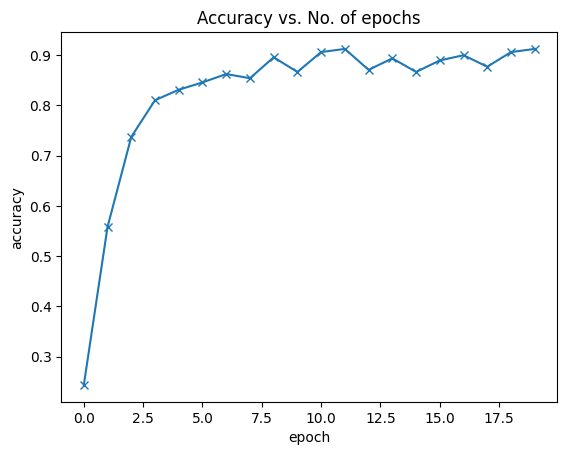

In [246]:
plot_accuracies(history)

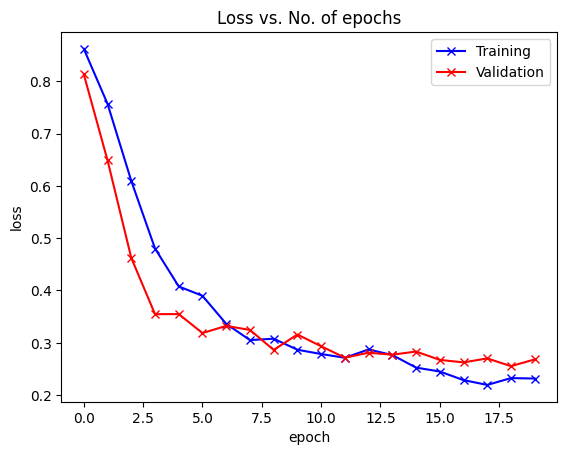

In [247]:
plot_losses(history)

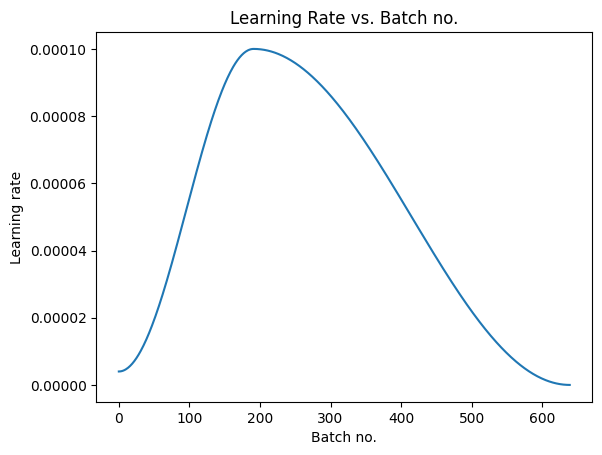

In [248]:
plot_lrs(history)

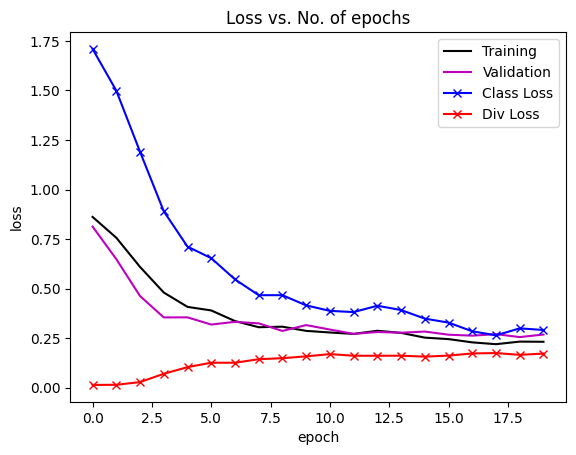

In [250]:
def plot_losses(history):
    cls_losses = [x.get('cls_loss') for x in history]
    div_losses = [x.get('div_loss') for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, 'k')
    plt.plot(val_losses, 'm')
    
    plt.plot(cls_losses, '-bx')
    plt.plot(div_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation', 'Class Loss','Div Loss'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history)

100%|██████████| 32/32 [00:03<00:00,  8.18it/s]


500 images
Classification Report: Train Dataset
Accuracy:  0.97
F1 Score:  0.969948597139771


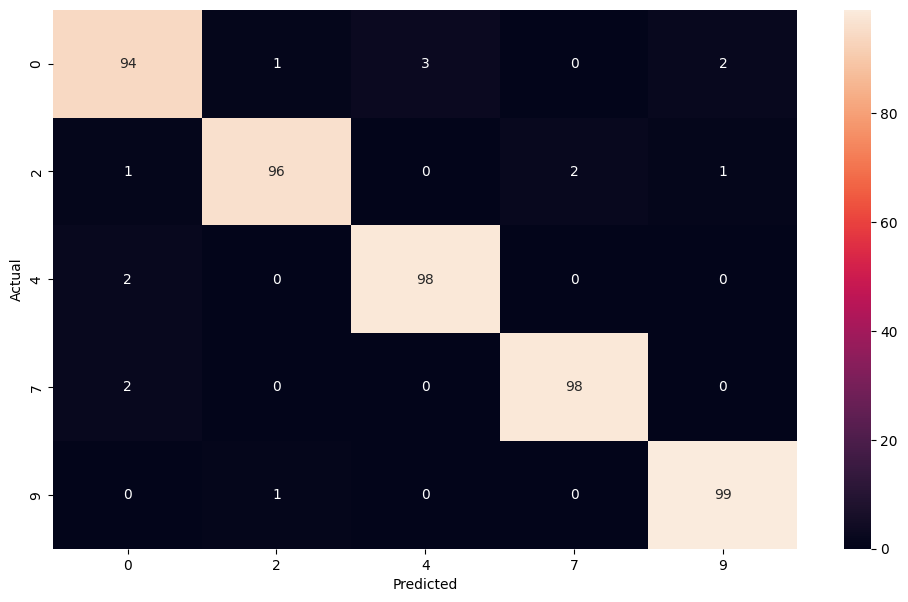

CPU times: user 7.84 s, sys: 210 ms, total: 8.05 s
Wall time: 4.37 s


<Figure size 640x480 with 0 Axes>

In [253]:
%%time
t_preds, t_trues = get_model_results(student_model,train_loader)
print_classification_report(t_trues,t_preds,'Train Dataset')

100%|██████████| 10/10 [00:00<00:00, 12.61it/s]


150 images
Classification Report: Validation Dataset
Accuracy:  0.9066666666666666
F1 Score:  0.9074921795804649


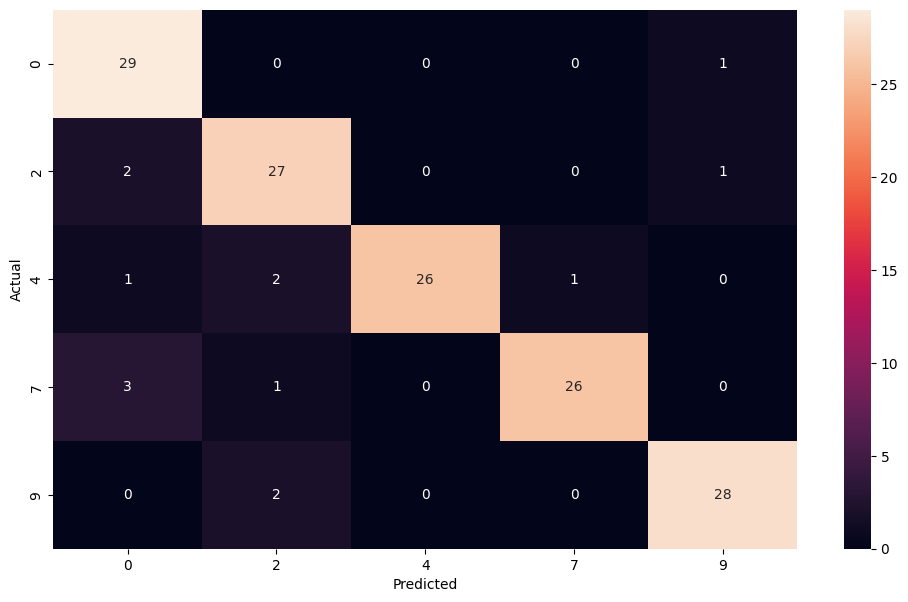

CPU times: user 2.06 s, sys: 155 ms, total: 2.21 s
Wall time: 1.25 s


<Figure size 640x480 with 0 Axes>

In [254]:
%%time
val_preds, val_trues = get_model_results(student_model,val_loader)
print_classification_report(val_trues,val_preds,'Validation Dataset')

100%|██████████| 63/63 [00:10<00:00,  6.17it/s]


1000 images
Classification Report: Test Dataset
Accuracy:  0.9
F1 Score:  0.8997565305339321


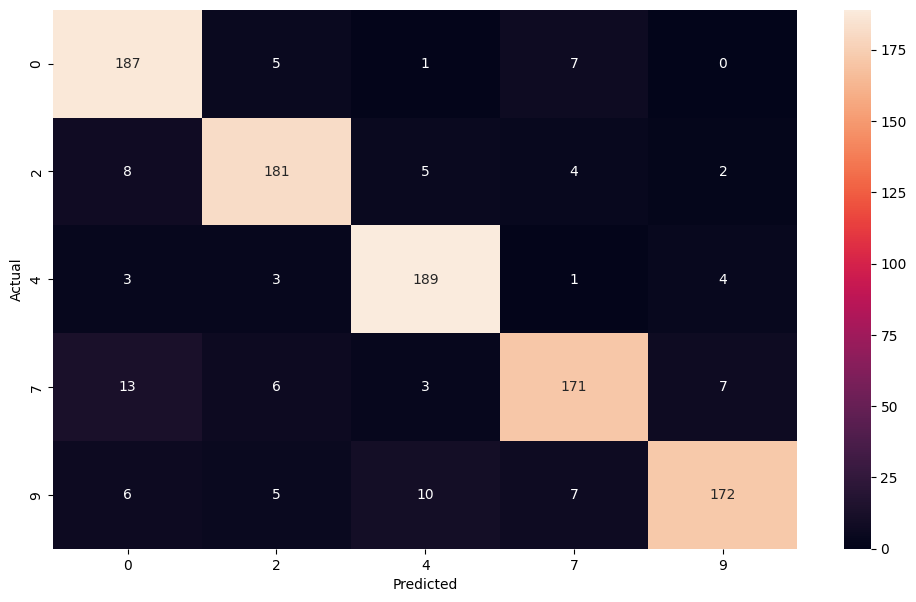

CPU times: user 15.1 s, sys: 327 ms, total: 15.4 s
Wall time: 10.6 s


<Figure size 640x480 with 0 Axes>

In [258]:
%%time
test_preds, test_trues = get_model_results(student_model,test_loader)
print_classification_report(test_trues,test_preds,'Test Dataset')

# Test classifier with 93.12% val acc during training

In [266]:
# Instantiate the student model
student_type = "Resnet18"
student_model1 = models.resnet18(pretrained=True)

# change the final layer of ResNet Model for Transfer Learning
fc_inputs = student_model1.fc.in_features
student_model1.fc = nn.Sequential(nn.Linear(fc_inputs, 5)) # change no. of classes

student_model1.load_state_dict(torch.load('/kaggle/working/Resnet18-student_of_VisionTransformer_3_93-12percent.pth'))
student_model1 = student_model1.to(device)
student_model1.eval()
summary(student_model1, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


500 images
Classification Report: Train Dataset
Accuracy:  0.954
F1 Score:  0.9538438857653379


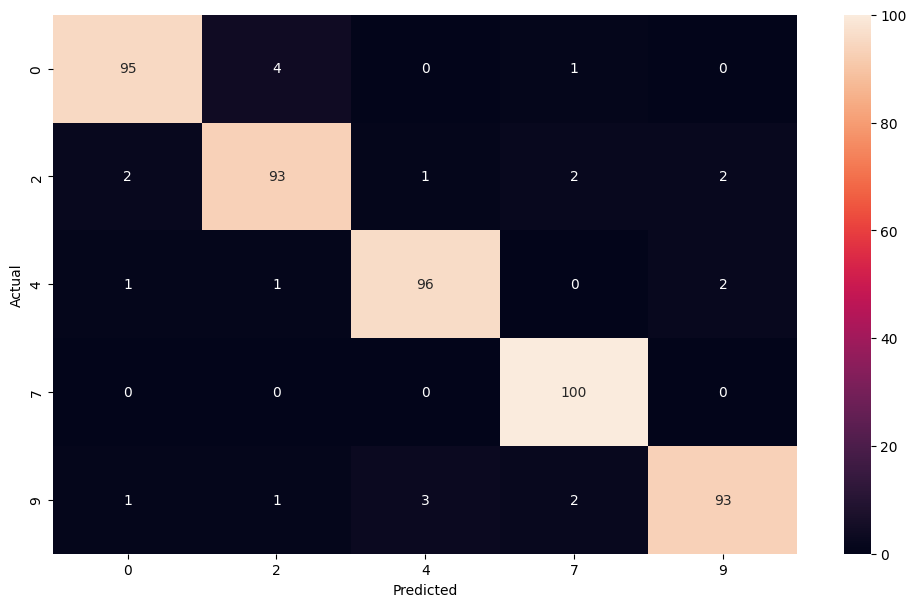

CPU times: user 8.24 s, sys: 231 ms, total: 8.47 s
Wall time: 5.17 s


<Figure size 640x480 with 0 Axes>

In [267]:
%%time
t_preds, t_trues = get_model_results(student_model1,train_loader)
print_classification_report(t_trues,t_preds,'Train Dataset')

100%|██████████| 10/10 [00:00<00:00, 12.11it/s]


150 images
Classification Report: Validation Dataset
Accuracy:  0.9266666666666666
F1 Score:  0.9259529183682321


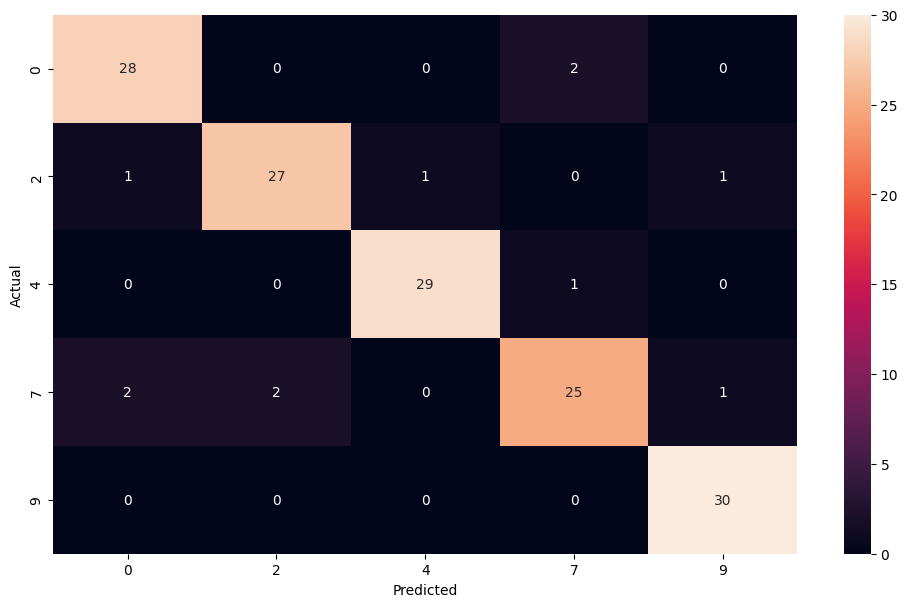

CPU times: user 2.01 s, sys: 186 ms, total: 2.2 s
Wall time: 1.24 s


<Figure size 640x480 with 0 Axes>

In [268]:
%%time
val_preds, val_trues = get_model_results(student_model1,val_loader)
print_classification_report(val_trues,val_preds,'Validation Dataset')

100%|██████████| 63/63 [00:05<00:00, 11.34it/s]


1000 images
Classification Report: Test Dataset
Accuracy:  0.876
F1 Score:  0.874855189200985


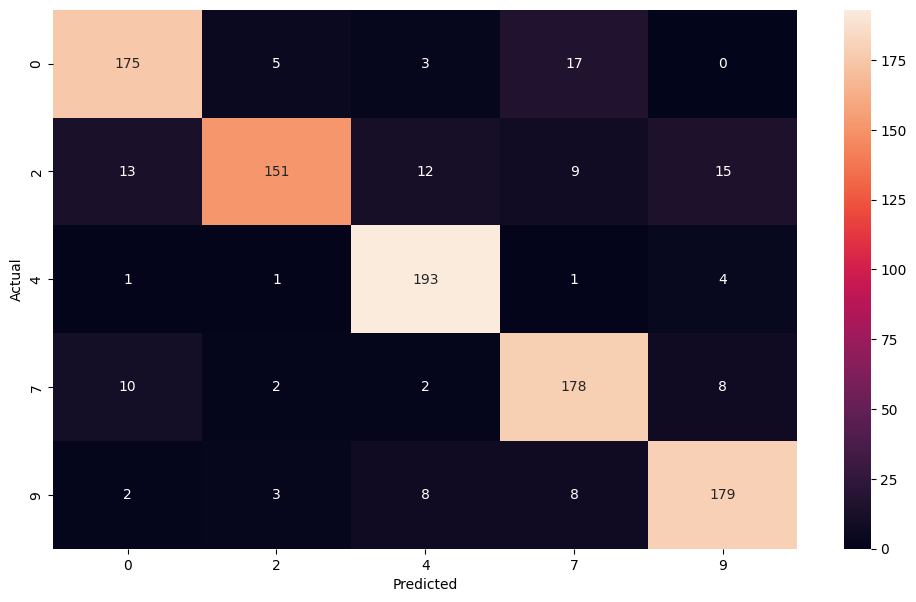

CPU times: user 10.7 s, sys: 290 ms, total: 11 s
Wall time: 6 s


<Figure size 640x480 with 0 Axes>

In [269]:
%%time
test_preds, test_trues = get_model_results(student_model1,test_loader)
print_classification_report(test_trues,test_preds,'Test Dataset')